<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/main/CNN_laboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN_Laboration
CNN laboration analyzing 4 different models with different parameters/layers that are trained on the MNIST fashion data set.
```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```

In [187]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

import tensorflow.keras 
print(f'Keras version:      {tensorflow.keras.__version__}')

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.7.0
Keras version:      2.7.0


In [188]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

No GPU detected. CNNs can be very slow without a GPU
Go to RunTime > change runtime and select a GPU hardware accelerator


In [189]:
def split_random(data, labels, percent_train=80):
    print('Splitting data into training and validation')
    print(f'Training split     = {percent_train}%')
    print(f'Validation split   = {100-percent_train}%')
    indicies = np.arange(data.shape[0])

    for _ in range(4): 
        indicies = np.random.permutation(indicies)

    
    labels = labels[indicies]
    data = data[indicies]
    rows = data.shape[0]

    end_index = int(rows*percent_train/100)

    train_x = data[:end_index]
    train_y = labels[:end_index]

    validation_x = data[end_index:]
    validation_y = labels[end_index:]

    return (train_x, train_y), (validation_x, validation_y)

In [190]:
def validate_data(data, labels, data_set_name):
    """
        Naive validation, only validets shape of data compared to labels
    """

    nr_images, x, y = data.shape
    print(f'\nRunning validation on {data_set_name}')
    print(f'Number of images   = {nr_images}')
    print(f'Number of labels   = {len(labels)}')
    print(f'Image dimension    = {x}x{y}')
    if nr_images != len(labels):
        print('Number of images does not match number of labels')
    else:
        print('Data is OK ✅')

In [191]:
def get_class_dist(data):
    dist = {}
    for label in data:
        if label in dist:
            dist[label] += 1
        else:
            dist[label] = 1
    return dist


# Loading and visualising the data
- Splits the training data set into a training / validation split (80/20)%
- Runs a naive validation on all data sets to see if the length of labels and images are matching.
- Visualize the data.

In [192]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
label_descriptions = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
                      'sandals', 'shirt', 'sneaker', 'bag', 'ankle boots']

(train_x, train_y), (validation_x, validation_y) = split_random(x_train, y_train)

# increase readability since i will use train_x, train_y from here on 
test_x = x_test
test_y = y_test
test_labels = y_test

validate_data(train_x, train_y, "training")
validate_data(validation_x, validation_y, "validation")
validate_data(test_x, test_y, "test")
distribution = get_class_dist(train_y)

print(f'\nTrain shape         = {train_x.shape}')
print(f'Validation shape    = {validation_x.shape}')
print(f'Test shape          = {x_test.shape}')
print(f'Unique labels       = {np.unique(train_y)}')
print('Label translation   = ---------------------')
for i, label in enumerate(label_descriptions):
    print(f'                     [{i}]: {label}')
print('Train distribution  = ---------------------')
for i, label in enumerate(label_descriptions):
    print('                     {:<20s}: {}'.format(label_descriptions[i], distribution[i]))
print('                     ---------------------')

Splitting data into training and validation
Training split     = 80%
Validation split   = 20%

Running validation on training
Number of images   = 48000
Number of labels   = 48000
Image dimension    = 28x28
Data is OK ✅

Running validation on validation
Number of images   = 12000
Number of labels   = 12000
Image dimension    = 28x28
Data is OK ✅

Running validation on test
Number of images   = 10000
Number of labels   = 10000
Image dimension    = 28x28
Data is OK ✅

Train shape         = (48000, 28, 28)
Validation shape    = (12000, 28, 28)
Test shape          = (10000, 28, 28)
Unique labels       = [0 1 2 3 4 5 6 7 8 9]
Label translation   = ---------------------
                     [0]: t-shirt/top
                     [1]: trouser
                     [2]: pullover
                     [3]: dress
                     [4]: coat
                     [5]: sandals
                     [6]: shirt
                     [7]: sneaker
                     [8]: bag
                     [9]: a

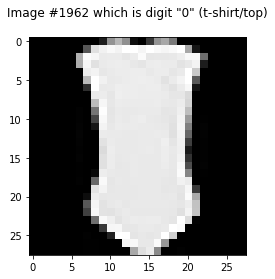

In [193]:
from random import randrange
def plot_image(digit):
    plt.figure()
    plt.imshow(train_x[digit], cmap='gray', interpolation='nearest')
    plt.title(f'Image #{digit} which is digit "{train_y[digit]}" ({label_descriptions[train_y[digit]]})\n')
    plt.show(block=False)

ran_range = len(train_x) - 1
image_digits = [randrange(ran_range)]
plots = [plot_image(a) for a in image_digits]


<Figure size 432x288 with 0 Axes>

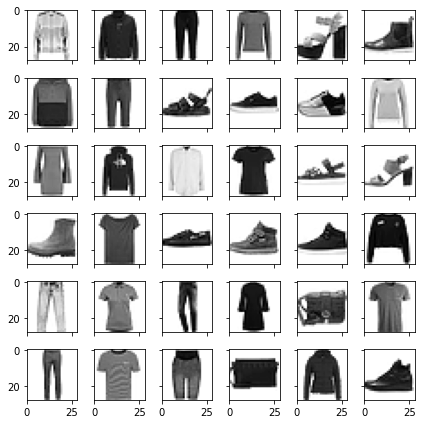

In [194]:
from random import sample
ROWS = 6
random_indicies = sample(range(train_x.shape[0]), ROWS*ROWS)
sample_images = train_x[random_indicies, :]
plt.clf()
fig, axes = plt.subplots(ROWS, ROWS, 
                         figsize=(ROWS, ROWS),
                         sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

# Reshaping the data
- Normalize the images (0-255 grayscale into 0-1 float)
- Reshape into correct shape

In [195]:
def reshape_data(data, img_width, img_height, channels_first):
    data = data.astype('float32') / 255.0

    if channels_first:
        data = data.reshape(data.shape[0], 1, img_width, img_height)
    else:
       data = data.reshape(data.shape[0], img_width, img_height, 1) 

    return data


In [196]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [197]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

In [198]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Declaring global variables
nr_classes = len(np.unique(train_y))
_, img_width, img_height = train_x.shape
is_channels_first = backend.image_data_format() == 'channels_first'
input_shape = (1, img_width, img_height) if is_channels_first else (img_width, img_height, 1)

train_x = reshape_data(train_x, img_width, img_height, is_channels_first)
test_x = reshape_data(test_x, img_width, img_height, is_channels_first)
validation_x = reshape_data(validation_x, img_width, img_height, is_channels_first)

train_y = to_categorical(train_y, nr_classes)
test_y = to_categorical(test_y, nr_classes)
validation_y = to_categorical(validation_y, nr_classes)

training_data = (train_x, train_y)
validation_data = (validation_x, validation_y)
test_data = (test_x, test_y)
models = []

# CNN Model
Defines a CNNModel, storing values for the history/score and provides an easy interface to create new models that will all share a common training and testing strategy. Creating a new model requires a Sequential model in the constructor. This design decicion was made to simplify creating and analyzing different CNN models.

# Main charactaristics

- Using default batchsize (32)
- Running training in 15 epochs with an early stop callback for all models
    - Early stopping is using 3 in patience, which means that it can go back 3 iterations (epochs) and will choose the best weights that it has encountered if the models validation loss starts to increase instead of decreasing (diverging).
- Learning rate is reduced to decrease overfitting (0.001 seems to be a bit too fast in this scenario).
- Using adam as optimizer for adaptive learning rates (considered among the best, if not the best!)
- Using **categorical_crossentropy** for loss & **categorical_accuracy** for accuracy


### Note
```
I know that layers and models can be extended upon using subclasses, 
however I thought that this solution is adequate for the given assignment.
```

In [199]:
class CNNModel():
    batch_size = 32
    epochs     = 15

    sequential = None
    stopped_at = None
    history    = None
    score      = None


    def __init__(self, sequential, name):
        self.name = name
        self.sequential = sequential
        self.stopped_at = self.epochs
        self.sequential.summary()

    def compile(self):
        optimizer = optimizers.Adam(learning_rate=0.0001)
        self.sequential.compile(loss='categorical_crossentropy',
                                optimizer=optimizer,
                                metrics=['categorical_accuracy'])
    
    def train(self, training_data, validation_data, verbose=1):
        early_stop_monitor = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks = [early_stop_monitor]
        train_x, train_y = training_data
        history = self.sequential.fit(train_x, train_y,
                                      batch_size=self.batch_size, 
                                      epochs=self.epochs,
                                      verbose=verbose,
                                      validation_data=validation_data,
                                      callbacks=callbacks)

        # Early stopped
        if early_stop_monitor.stopped_epoch != 0:
            self.stopped_at = early_stop_monitor.stopped_epoch

        self.history = history.history
    
    def evaluate(self, test_data):
        test_x, test_y = test_data
        score = self.sequential.evaluate(test_x, test_y)
        self.score = score

    def plot_history(self):
        train_loss, train_acc, val_loss, val_acc = retrieve(self.history, 
                                                            'loss',
                                                            'categorical_accuracy',
                                                            'val_loss',
                                                            'val_categorical_accuracy')
        early_stop_label = f'Stopped at {self.stopped_at}'
        epoch_range = range(1, self.stopped_at + 1)
        plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
        plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
        plt.title(f'Training and validation accuracy ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.axvline(x=self.stopped_at, label=early_stop_label, color='k', ls='--')
        plt.legend()
        plt.show()

        plt.plot(epoch_range, train_loss, 'bo', color='red', label='Training loss')
        plt.plot(epoch_range, val_loss, 'b', color='red', label='Validation loss')
        plt.title(f'Training and validation loss ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.axvline(x=self.stopped_at, label=early_stop_label, color='k', ls='--')
        plt.legend()
        plt.show()
        print()
    

# One layered simple CNN

In [200]:
one_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(one_layer_cnn, 'One layer CNN with 3x3 kernel'))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 flatten_30 (Flatten)        (None, 5408)              0         
                                                                 
 dense_60 (Dense)            (None, 128)               692352    
                                                                 
 dense_61 (Dense)            (None, 10)                1290      
                                                     

# One layered CNN with a 6x6 kernel size

In [201]:
seq_6x6 = Sequential([
    Conv2D(32, kernel_size=(6,6), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(seq_6x6, 'One layered CNN with 6x6 kernel'))

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 23, 23, 32)        1184      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 flatten_31 (Flatten)        (None, 3872)              0         
                                                                 
 dense_62 (Dense)            (None, 128)               495744    
                                                                 
 dense_63 (Dense)            (None, 10)                1290      
                                                     

# Two layered CNN

In [202]:
two_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

models.append(CNNModel(two_layer_cnn, 'Two layered CNN'))

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 6, 6, 64)        

# Complex multilayered CNN

In [203]:
complex_cnn = Sequential([

    Conv2D(32, kernel_size=(3,3), padding='same', 
           activation='relu',
           input_shape=input_shape),
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax'),
])

models.append(CNNModel(complex_cnn, 'Complex multilayered CNN'))

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_66 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_68 (Conv2D)          (None, 14, 14, 64)        36928     
                                                     

In [204]:
import time
for model in models:
    print(f'Begin training model: {model.name}')
    start_time = time.time();
    model.compile()
    model.train(training_data, validation_data)
    elapsed_time = time.time() - start_time
    print(f'Training finished in {hms_string(elapsed_time)}\n')


Begin training model: One layer CNN with 3x3 kernel
Epoch 1/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.6169 - categorical_accuracy: 0.7896 - val_loss: 0.4364 - val_categorical_accuracy: 0.8465
Epoch 2/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.4224 - categorical_accuracy: 0.8500 - val_loss: 0.3674 - val_categorical_accuracy: 0.8728
Epoch 3/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.3778 - categorical_accuracy: 0.8660 - val_loss: 0.3406 - val_categorical_accuracy: 0.8795
Epoch 4/15
1066/1500 [====================>.........] - ETA: 10s - loss: 0.3508 - categorical_accuracy: 0.8758

KeyboardInterrupt: ignored

# Training history (loss + acc)



In [ ]:
for model in models:
    model.plot_history()

# Test comparison

In [ ]:
for model in models: 
    model.evaluate(test_data)

best_acc = max(models, key=lambda m: m.score[1])
least_loss = min(models, key=lambda m: m.score[0])

In [ ]:
print(f'Model with highest test accuracy: {best_acc.name}')
print(f'Test accuracy = {best_acc.score[1]}')

best_acc.sequential.summary()

In [ ]:
for model in models:
    predictions = model.sequential.predict(test_x[:5])
    print(f'Letting model {model.name} predict on 5 samples')
    print(f'Model predicted labels     = {np.argmax(predictions, axis=1)}')
    print(f'Actual labels are          = {test_labels[:5]}')
    print()

# Conclusion
